In [1]:
import sys
import os
try:
    import warnings                                                   
    warnings.filterwarnings('ignore')     
    import pandas as pd       
    import numpy as np
    import sqlite3
    import watermark
    import pymc3 as pm
    from pymc3.math import invlogit
    import theano.tensor as tt
    import xarray as xr
    import arviz as az
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cbook as cbook
    # import jotaviz
    from datetime import datetime, timedelta
    from scipy.special import expit as logistic
    from IPython.display import display, HTML
    from dateutil.relativedelta import relativedelta

except ImportError:
    print("Error: missing one of the libraries..")
    sys.exit()

sys.path.append('../..')

%matplotlib inline

# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print(os.getcwd())
print(sys.argv[0])
print('Running on pymc3 v{}'.format(pm.__version__))
print('Running on arviz v{}'.format(az.__version__))

PRIOR_N = 50.
ELECTION_DATE = '2021-12-30'

/Users/marcelino/dmarcelinobr/pollbase/dashboards/models
/Users/marcelino/Library/Python/3.8/lib/python/site-packages/ipykernel_launcher.py
Running on pymc3 v3.11.4
Running on arviz v0.11.2


In [2]:

def exp_decay(data_date, election_date):
    '''Weights polls with exponential decay setting 30 days before election at 0.5 weight'''
    # calculate time delta 
    td = (election_date - data_date).days
    
    # calculate the exponential decay
    return 0.5 ** (td / 30.)

In [3]:
con = sqlite3.connect('../../pollingpoints.db')

file_long = pd.read_sql(""" SELECT data_ini, data_fim, empresa,
turno, candidato, voto, erro, amostra, tipo, modo FROM eleitoral WHERE tipo = 'Bolsonaro x Lula' 
OR  tipo = 'Lula x Moro' AND cargo = 'Presidente' ORDER BY data_fim;""", con=con) 

con.close()

In [4]:
# Converte para datetime 
file_long["data_fim"] = pd.to_datetime(file_long["data_fim"])

# sort by field date
file_long = file_long.sort_index(axis=0)

# Create indecisos e branco/nulo
file_long["candidato"] = file_long["candidato"].replace("NS/NR", "Indecisos")
file_long["candidato"] = file_long["candidato"].replace("Branco/Nulo/NS/NR", "Branco/Nulo")

# Replace NA with 1000 interviews 
file_long["amostra"] = file_long["amostra"].replace(np.nan, 1000)

# Convert vote intention rates to proportion 
# file_long[["voto", "erro"]] = (file_long[["voto", "erro"]].copy()/100)

data = file_long.query("tipo == 'Bolsonaro x Lula' | tipo == 'Lula x Moro'")

data.head()

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo
0,2020-08-24,2020-08-31,IDEIA,2,Branco/Nulo,21.0,3.0,1235,Bolsonaro x Lula,CATI
1,2020-08-24,2020-08-31,IDEIA,2,Jair Bolsonaro,42.0,3.0,1235,Bolsonaro x Lula,CATI
2,2020-08-24,2020-08-31,IDEIA,2,Lula da Silva,31.0,3.0,1235,Bolsonaro x Lula,CATI
3,2020-08-24,2020-08-31,IDEIA,2,Indecisos,6.0,3.0,1235,Bolsonaro x Lula,CATI
4,2021-03-08,2021-03-10,Atlas,2,Branco/Nulo,16.3,3.0,3721,Bolsonaro x Lula,Online


In [5]:
candidatos = data['candidato'].unique().tolist()
candidatos 


['Branco/Nulo', 'Jair Bolsonaro', 'Lula da Silva', 'Indecisos', 'Sergio Moro']

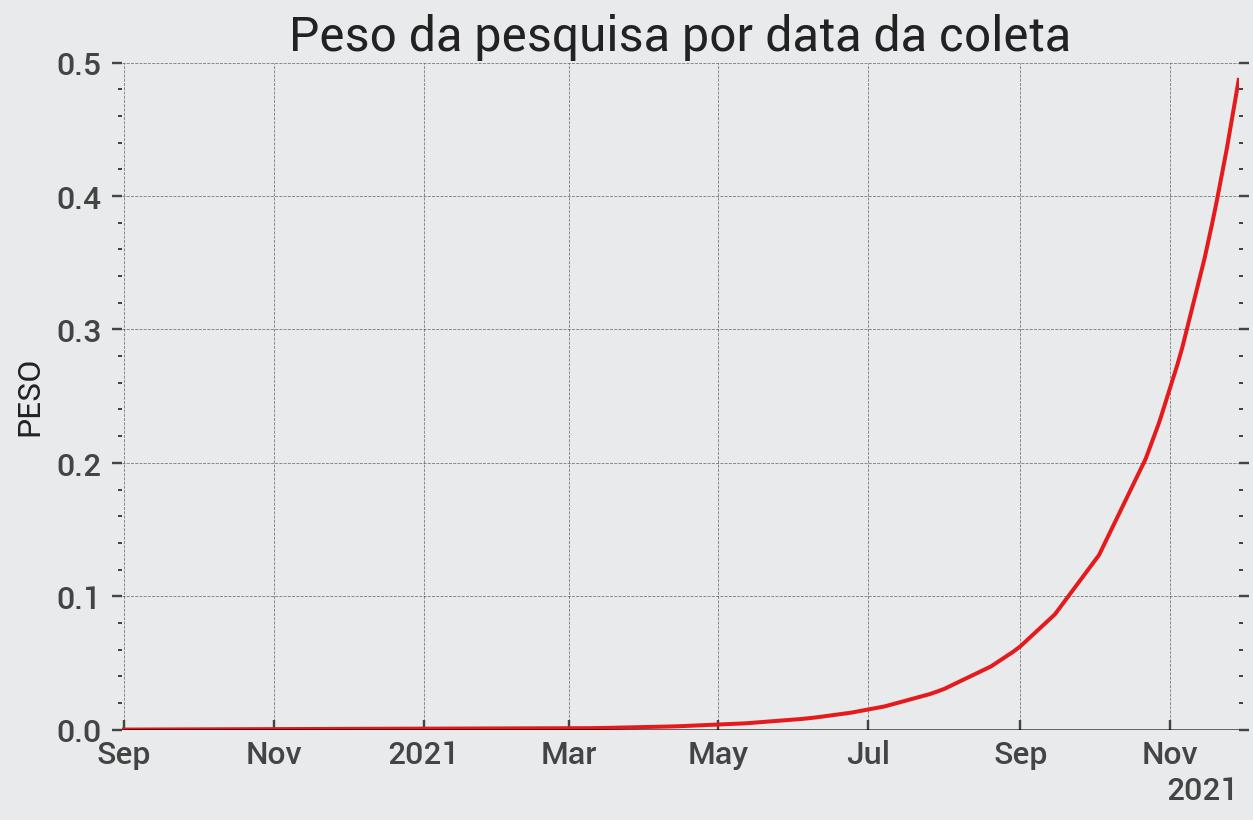

In [6]:
# weight the poll by end date
data['weight'] = data['data_fim'].apply(exp_decay, args=(datetime.strptime(ELECTION_DATE, '%Y-%m-%d'),))
# data['weight'] = 1

    
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.plot(data.data_fim, data.weight, linewidth=2)
    ax.set_ylabel(f'PESO')
    ax.set_title(f'Peso da pesquisa por data da coleta', fontsize=24)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
    fig.tight_layout();
    plt.savefig('../figures/exponential_decay.png', dpi=300)

In [7]:
# apply weight to sample size
data['amostra'] = data['amostra'] * data['weight']
data

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
0,2020-08-24,2020-08-31,IDEIA,2,Branco/Nulo,21.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
1,2020-08-24,2020-08-31,IDEIA,2,Jair Bolsonaro,42.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
2,2020-08-24,2020-08-31,IDEIA,2,Lula da Silva,31.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
3,2020-08-24,2020-08-31,IDEIA,2,Indecisos,6.0,3.0,0.016405,Bolsonaro x Lula,CATI,0.000013
4,2021-03-08,2021-03-10,Atlas,2,Branco/Nulo,16.3,3.0,4.078790,Bolsonaro x Lula,Online,0.001096
...,...,...,...,...,...,...,...,...,...,...,...
160,2021-11-27,2021-11-29,Atlas,2,Branco/Nulo,24.4,1.0,2150.240511,Lula x Moro,Online,0.488580
161,2021-11-27,2021-11-29,Atlas,2,Jair Bolsonaro,36.0,1.0,2150.240511,Bolsonaro x Lula,Online,0.488580
162,2021-11-27,2021-11-29,Atlas,2,Lula da Silva,50.5,1.0,2150.240511,Bolsonaro x Lula,Online,0.488580
163,2021-11-27,2021-11-29,Atlas,2,Lula da Silva,46.4,1.0,2150.240511,Lula x Moro,Online,0.488580


# Bolsonaro (PL) vs Lula (PT)

In [8]:
# Nov 3, 2020 results used as prior (total party support used as prior)
b_pct = .40
l_pct = .45

# normalize the split because the race is only between the two now
b_pct_norm = b_pct / (b_pct + l_pct)
l_pct_norm = l_pct / (b_pct + l_pct)

b_pct_norm, l_pct_norm

(0.47058823529411764, 0.5294117647058824)

In [9]:
lula_polls = data.query("tipo == 'Bolsonaro x Lula' & candidato == 'Lula da Silva'")
# only use most recent poll from empresa that do multiple
lula_polls = lula_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
21,2021-06-01,2021-06-04,Ranking Brasil,2,Lula da Silva,47.07,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995
52,2021-07-07,2021-07-08,Orbis,2,Lula da Silva,46.80,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538
83,2021-09-13,2021-09-15,Datafolha,2,Lula da Silva,56.00,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370
104,2021-10-25,2021-10-28,Ipespe,2,Lula da Silva,50.00,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258
109,2021-10-30,2021-11-04,Vox Populi,2,Lula da Silva,52.00,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206
114,2021-11-03,2021-11-06,Quaest,2,Lula da Silva,57.00,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175
122,2021-11-12,2021-11-15,IDEIA,2,Lula da Silva,48.00,3.0,424.264069,Bolsonaro x Lula,CATI,0.353553
130,2021-11-16,2021-11-18,Ponteio,2,Lula da Silva,50.00,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929
138,2021-11-16,2021-11-19,Paraná,2,Lula da Silva,42.50,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786
146,2021-11-16,2021-11-20,Futura,2,Lula da Silva,49.20,2.2,793.700526,Bolsonaro x Lula,CATI,0.396850


In [10]:
bolsonaro_polls = data.query("tipo == 'Bolsonaro x Lula' & candidato == 'Jair Bolsonaro'")
# only use most recent poll from pollsters that do multiple
bolsonaro_polls = bolsonaro_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
bolsonaro_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
20,2021-06-01,2021-06-04,Ranking Brasil,2,Jair Bolsonaro,35.13,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995
51,2021-07-07,2021-07-08,Orbis,2,Jair Bolsonaro,38.90,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538
82,2021-09-13,2021-09-15,Datafolha,2,Jair Bolsonaro,31.00,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370
103,2021-10-25,2021-10-28,Ipespe,2,Jair Bolsonaro,32.00,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258
108,2021-10-30,2021-11-04,Vox Populi,2,Jair Bolsonaro,24.00,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206
113,2021-11-03,2021-11-06,Quaest,2,Jair Bolsonaro,27.00,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175
121,2021-11-12,2021-11-15,IDEIA,2,Jair Bolsonaro,31.00,3.0,424.264069,Bolsonaro x Lula,CATI,0.353553
129,2021-11-16,2021-11-18,Ponteio,2,Jair Bolsonaro,32.00,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929
137,2021-11-16,2021-11-19,Paraná,2,Jair Bolsonaro,35.60,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786
145,2021-11-16,2021-11-20,Futura,2,Jair Bolsonaro,37.40,2.2,793.700526,Bolsonaro x Lula,CATI,0.396850


In [11]:
poll_normalizer = lula_polls[['empresa', 'voto', 'data_fim']].merge(bolsonaro_polls[['empresa', 'voto', 'data_fim']], on=['empresa', 'data_fim'])
poll_normalizer['normalizer'] = poll_normalizer['voto_x'] + poll_normalizer['voto_y']
poll_normalizer['voto_x'] /= poll_normalizer['normalizer']
poll_normalizer['voto_y'] /= poll_normalizer['normalizer']
poll_normalizer 

,empresa,voto_x,data_fim,voto_y,normalizer
0,Ranking Brasil,0.572628,2021-06-04,0.427372,82.2
1,Orbis,0.546091,2021-07-08,0.453909,85.7
2,Datafolha,0.643678,2021-09-15,0.356322,87.0
3,Ipespe,0.609756,2021-10-28,0.390244,82.0
4,Vox Populi,0.684211,2021-11-04,0.315789,76.0
5,Quaest,0.678571,2021-11-06,0.321429,84.0
6,IDEIA,0.607595,2021-11-15,0.392405,79.0
7,Ponteio,0.609756,2021-11-18,0.390244,82.0
8,Paraná,0.544174,2021-11-19,0.455826,78.1
9,Futura,0.568129,2021-11-20,0.431871,86.6


In [12]:
# add in the normalized values to lula polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _empresa, _voto = norm_row['data_fim'], norm_row['empresa'], norm_row['voto_x']
    lula_polls.loc[(lula_polls.data_fim == _date) & (lula_polls.empresa == _empresa), 'voto'] = _voto
    
lula_polls['num_votos'] = lula_polls['amostra'] * lula_polls['voto']
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight,num_votos
21,2021-06-01,2021-06-04,Ranking Brasil,2,Lula da Silva,0.572628,2.5,23.985326,Bolsonaro x Lula,CATI,0.007995,13.734663
52,2021-07-07,2021-07-08,Orbis,2,Lula da Silva,0.546091,1.8,52.475101,Bolsonaro x Lula,Internet,0.017538,28.656181
83,2021-09-13,2021-09-15,Datafolha,2,Lula da Silva,0.643678,2.0,316.717158,Bolsonaro x Lula,Presencial,0.086370,203.863918
104,2021-10-25,2021-10-28,Ipespe,2,Lula da Silva,0.609756,3.2,233.258248,Bolsonaro x Lula,CATI,0.233258,142.230639
109,2021-10-30,2021-11-04,Vox Populi,2,Lula da Silva,0.684211,2.2,548.412490,Bolsonaro x Lula,Presencial,0.274206,375.229598
114,2021-11-03,2021-11-06,Quaest,2,Lula da Silva,0.678571,2.2,592.441177,Bolsonaro x Lula,Presencial,0.287175,402.013656
122,2021-11-12,2021-11-15,IDEIA,2,Lula da Silva,0.607595,3.0,424.264069,Bolsonaro x Lula,CATI,0.353553,257.780700
130,2021-11-16,2021-11-18,Ponteio,2,Lula da Silva,0.609756,3.0,378.929142,Bolsonaro x Lula,CATI,0.378929,231.054355
138,2021-11-16,2021-11-19,Paraná,2,Lula da Silva,0.544174,2.0,783.328105,Bolsonaro x Lula,Presencial,0.387786,426.266894
146,2021-11-16,2021-11-20,Futura,2,Lula da Silva,0.568129,2.2,793.700526,Bolsonaro x Lula,CATI,0.396850,450.924548


In [13]:
# group by pollster
lula_bolsonaro_empresas = (
    lula_polls[['empresa', 'amostra', 'num_votos']]
    .groupby('empresa')
    .agg(np.sum)
)
lula_bolsonaro_empresas

,amostra,num_votos
empresa,,
Atlas,2150.240511,1255.342726
Datafolha,316.717158,203.863918
Futura,793.700526,450.924548
IDEIA,424.264069,257.780700
Ipespe,233.258248,142.230639
Orbis,52.475101,28.656181
Paraná,783.328105,426.266894
PoderData,1088.188204,691.319565
Ponteio,378.929142,231.054355


In [14]:
# tune n for how much we want the model to 
alpha = int(l_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(26, 24.0)

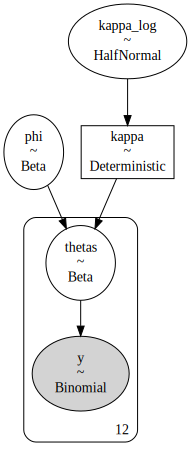

In [15]:
with pm.Model() as lula_bolsonaro_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=10)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(lula_bolsonaro_empresas)
    )
    
    y = pm.Binomial(
        'y', 
        n=lula_bolsonaro_empresas['amostra'], 
        p=thetas, 
        observed=lula_bolsonaro_empresas['num_votos']
    )

# Save imagem
pc = pm.model_to_graphviz(lula_bolsonaro_model)
pc.render("../figures/lula_bolsonaro_model", format="png")

pm.model_to_graphviz(lula_bolsonaro_model)

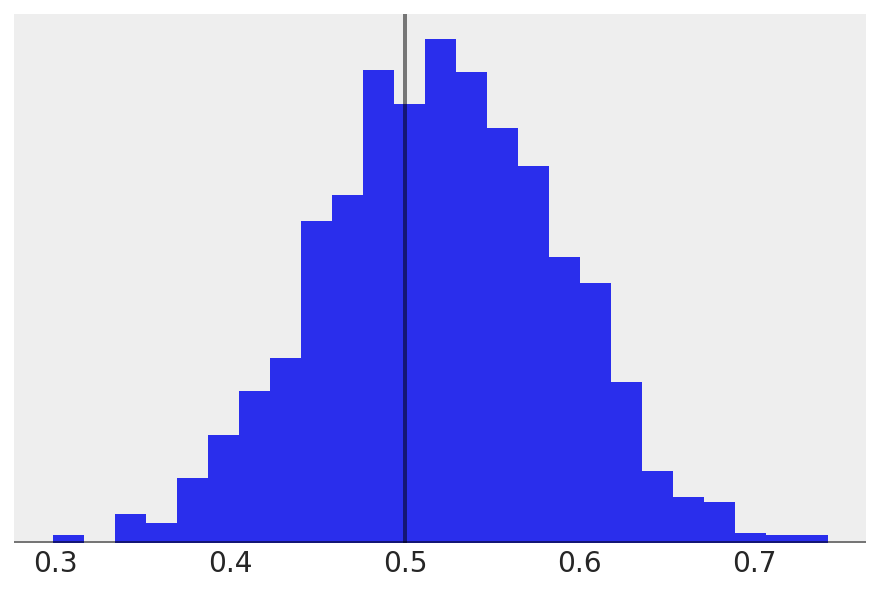

In [16]:
with lula_bolsonaro_model:
    lula_bolsonaro_prior = pm.sample_prior_predictive(samples=2000)
    
plt.hist(lula_bolsonaro_prior['phi'], bins=25)
plt.axhline(y=0, color='black', alpha=0.5, linewidth=2)
plt.axvline(x=0.5, color='black', alpha=0.5, linewidth=2)
plt.grid(linestyle=':')
plt.yticks([])
plt.show()

In [36]:
# Explore and Sample the Parameter Space
with lula_bolsonaro_model:
    step = pm.Metropolis()
    lula_bolsonaro_samples = pm.sample(2000, tune=3000, cores=4, chains=6, target_accept=0.990) 
    # post_pred = pm.sample_posterior_predictive(lula_bolsonaro_samples, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 6 chains for 3_000 tune and 2_000 draw iterations (18_000 + 12_000 draws total) took 63 seconds.


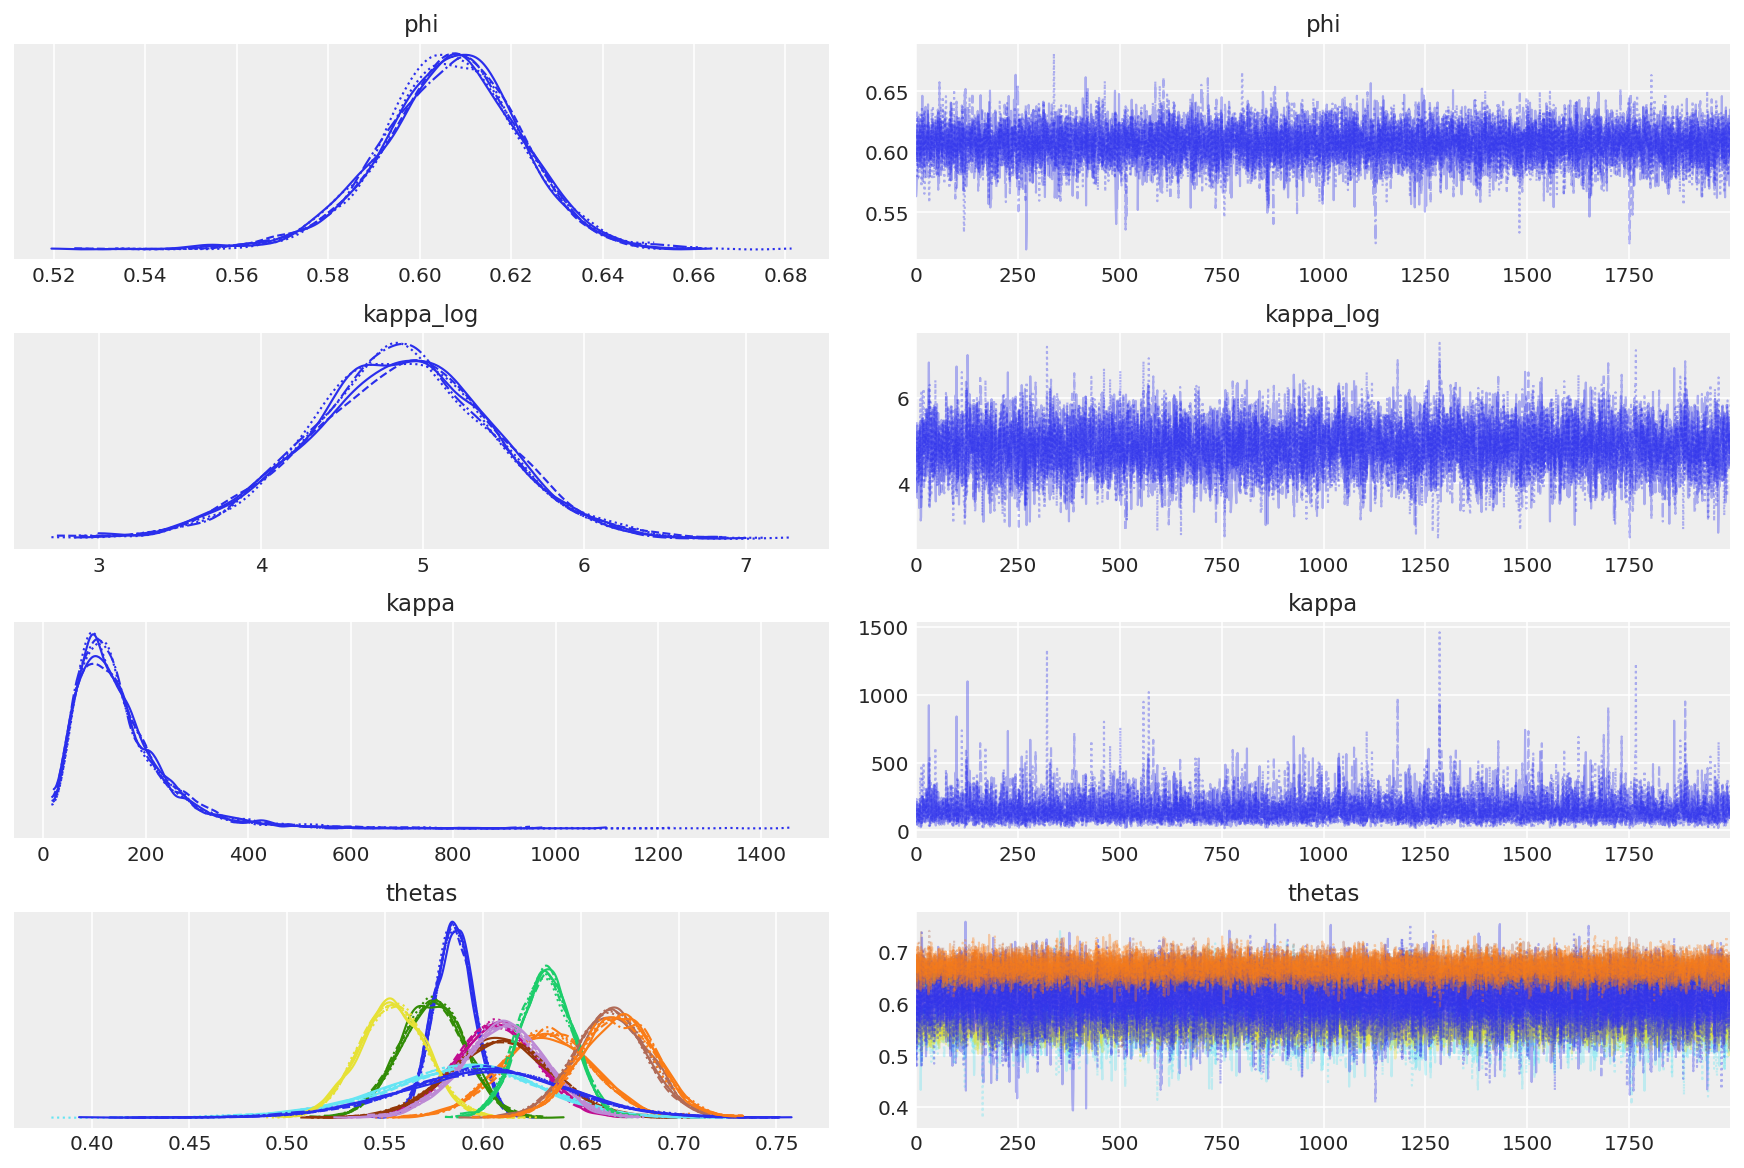

In [19]:
pm.traceplot(lula_bolsonaro_samples)
plt.show()

In [ ]:
pm.summary(lula_bolsonaro_samples, hdi_prob=0.94)

In [20]:
map_estimate = pm.find_MAP(model=lula_bolsonaro_model)
map_estimate['phi']

array(0.61045471)

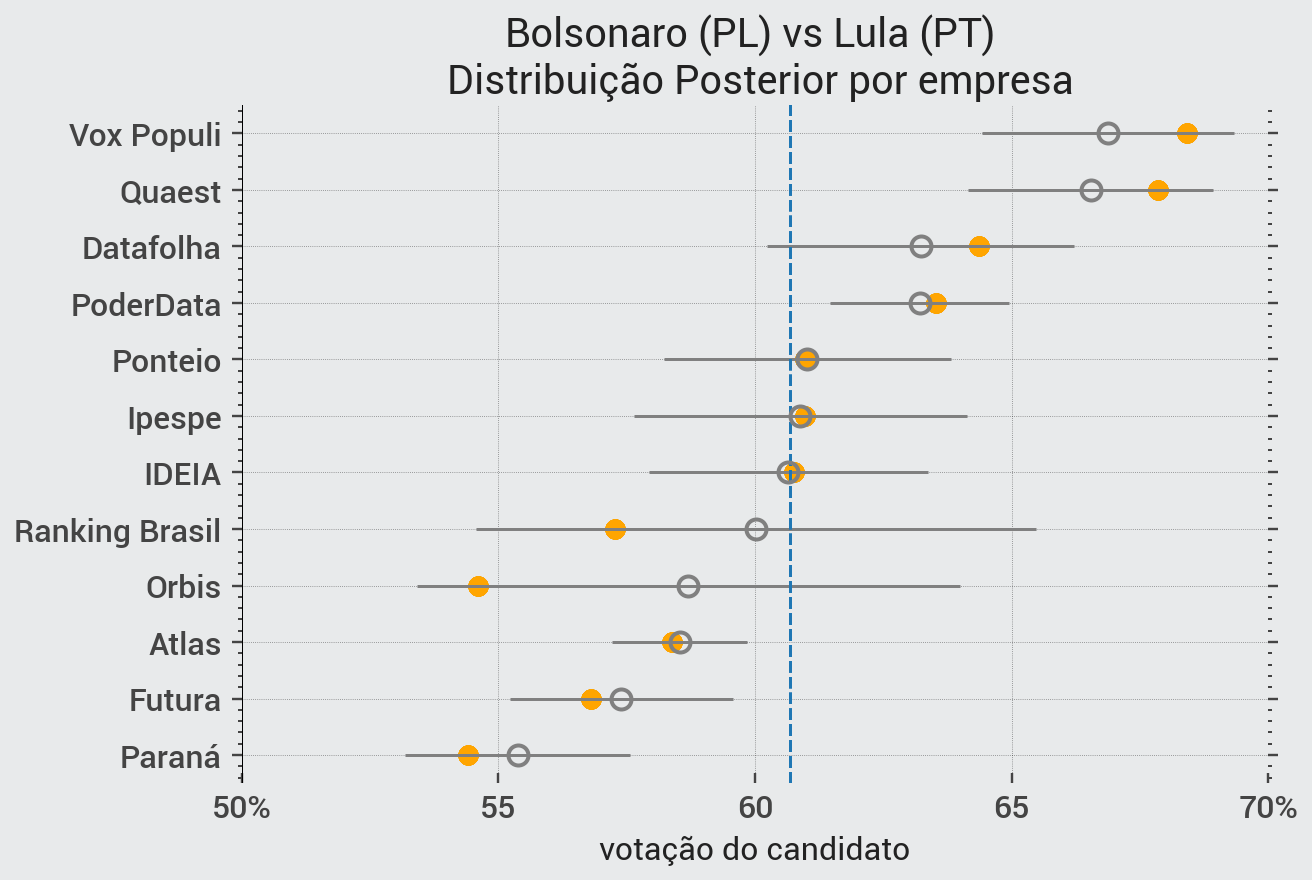

In [21]:
import scipy.stats as stats

medians = []
errs = []
labels = []
for empresa_idx in range(lula_bolsonaro_samples['thetas'].shape[1]):
    _median = np.mean(lula_bolsonaro_samples['thetas'][:,empresa_idx])
    lower, _ = np.percentile(lula_bolsonaro_samples['thetas'][:,empresa_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(lula_bolsonaro_empresas.index.tolist()[empresa_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)


with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    #medians, errs, labels
    for idx, _median in enumerate(medians):
        plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
        for empresa_idx, empresa in enumerate(labels):
            plt.scatter(
                x=(
                    lula_bolsonaro_empresas[lula_bolsonaro_empresas.index == empresa]['num_votos'] / 
                    lula_bolsonaro_empresas[lula_bolsonaro_empresas.index == empresa]['amostra']), 
                y=empresa_idx, color='orange')
        plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
        plt.axvline(x=np.mean(lula_bolsonaro_samples['phi']), linestyle='--', color='tab:blue')
        plt.grid(linestyle=':')
        plt.yticks(np.arange(len(lula_bolsonaro_empresas)), labels)
        plt.xlabel('votação do candidato')
        plt.title('Bolsonaro (PL) vs Lula (PT) \n Distribuição Posterior por empresa', fontsize=20)
        ax.set_xticks(ticks = [.50, .55, .60, .65, .70])
        ax.set_xticklabels(labels = ['50%', '55', '60', '65', '70%'])
        yticks, yticklabels = plt.yticks()
        ymin = (3*yticks[0] - yticks[1])/2.
        # shaft half a step to the right
        ymax = (3*yticks[-1] - yticks[-2])/2.
        plt.ylim(ymin, ymax)
        plt.yticks(yticks)

plt.savefig('../figures/lula_bolsonaro_tendendcia_empresa.png', dpi=300)

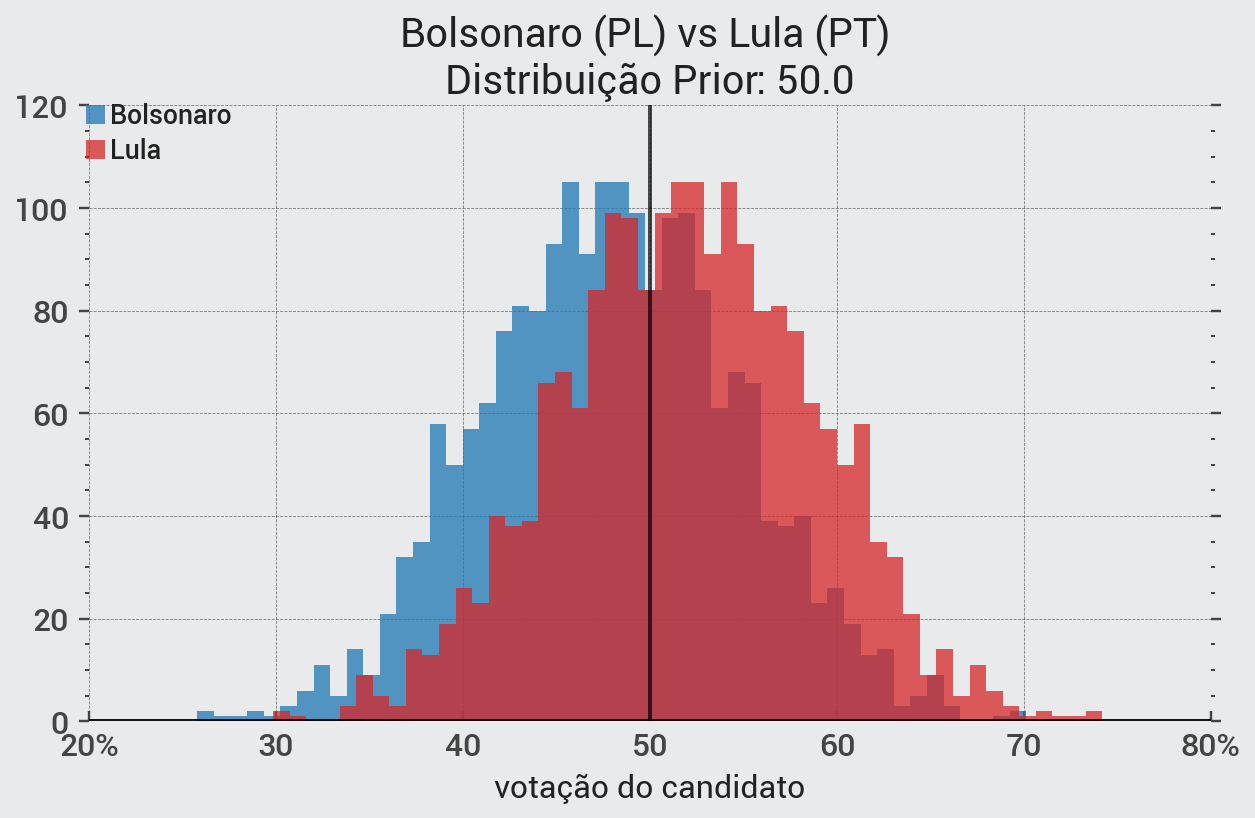

In [22]:

with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_bolsonaro_prior['phi']), color='tab:blue', alpha=0.75, bins=50, label='Bolsonaro')
    ax.hist(lula_bolsonaro_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Bolsonaro (PL) vs Lula (PT) \nDistribuição Prior: {}'.format(PRIOR_N), fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.20, .30, .40, .50, .60, .70, .80])
    ax.set_xticklabels(labels = ['20%', '30', '40', '50', '60', '70', '80%'])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/bolsonaro_lula_{}-priors.png'.format(PRIOR_N))

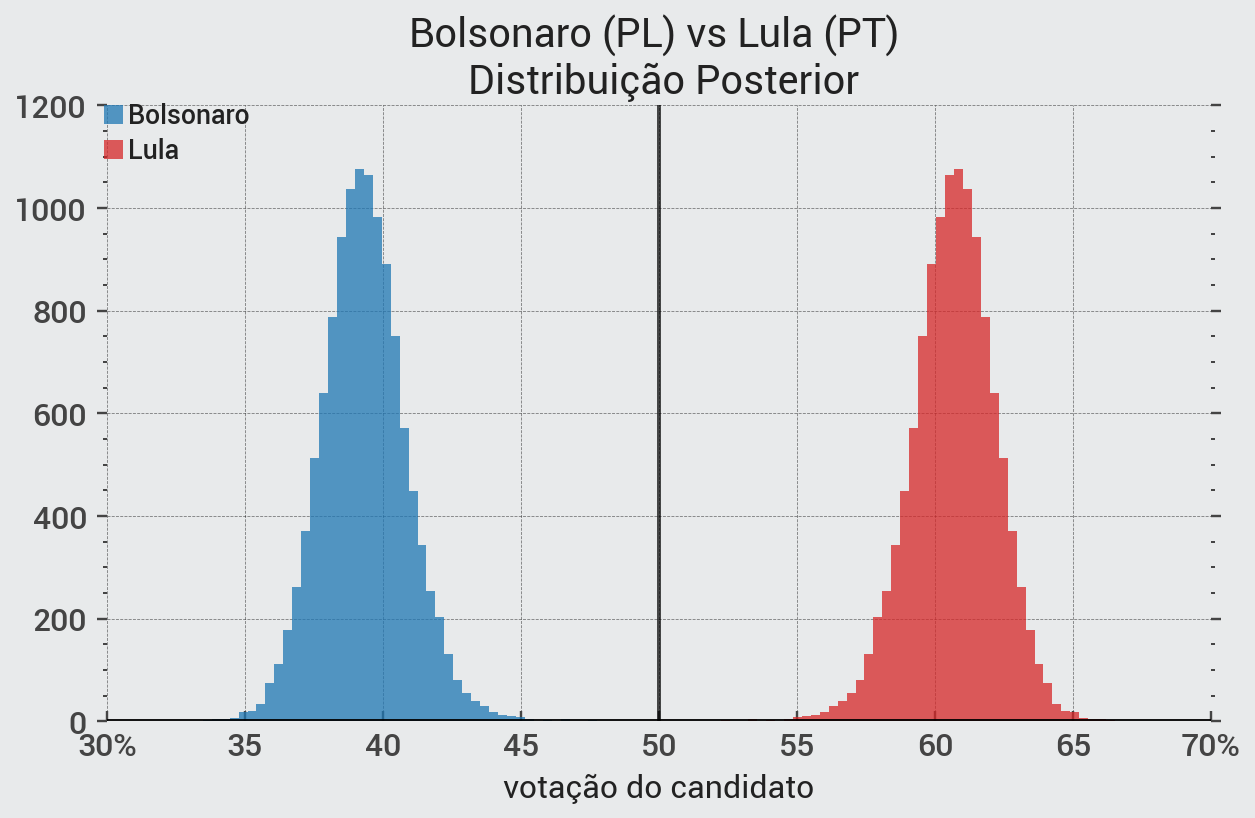

In [23]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_bolsonaro_samples['phi']), color='tab:blue', alpha=0.75, bins=50, label='Bolsonaro')
    ax.hist(lula_bolsonaro_samples['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Bolsonaro (PL) vs Lula (PT) \n Distribuição Posterior', fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.30, .35, .40, .45, .50, .55, .60, .65, .70])
    ax.set_xticklabels(labels = ['30%', '35', '40', '45', '50', '55', '60', '65', '70%'])
    # ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/bolsonaro_lula_posteriors.png')


In [24]:
print("Probabilidade de vitória de Lula no 2º turno:", round(np.mean(lula_bolsonaro_samples['phi'] > 0.55),3));
print("Probabilidade de vitória de Bolsonaro no 2º turno:", round(np.mean(1. - lula_bolsonaro_samples['phi'] > 0.45),3))

Probabilidade de vitória de Lula no 2º turno: 0.998
Probabilidade de vitória de Bolsonaro no 2º turno: 0.002


# Lula (PT) vs Moro (PODE)

In [25]:
# Nov 3, 2020 results used as prior
l_pct = 0.45
m_pct = 0.40

# normalize the split because the race is only between the two now
l_pct_norm = l_pct / (l_pct + m_pct)
m_pct_norm = m_pct / (m_pct + l_pct)

l_pct_norm, m_pct_norm

(0.5294117647058824, 0.47058823529411764)

In [27]:
lula_polls = data.query("tipo == 'Lula x Moro' & candidato == 'Lula da Silva'")
# only use most recent poll from pollsters that do multiple
# lula_polls = lula_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
15,2021-05-11,2021-05-12,Datafolha,1,Lula da Silva,53.0,2.0,9.732285,Lula x Moro,Presencial,0.004699
28,2021-06-07,2021-06-10,Ipespe,2,Lula da Silva,43.0,3.2,9.183968,Lula x Moro,CATI,0.009184
34,2021-06-22,2021-06-24,IDEIA,2,Lula da Silva,44.0,3.0,15.229732,Lula x Moro,CATI,0.012691
44,2021-07-05,2021-07-07,Ipespe,2,Lula da Silva,48.0,3.2,17.137890,Lula x Moro,CATI,0.017138
65,2021-07-29,2021-08-01,Quaest,2,Lula da Silva,54.0,3.0,45.804374,Lula x Moro,Presencial,0.030536
89,2021-09-30,2021-10-03,Quaest,2,Lula da Silva,52.0,3.0,268.107295,Lula x Moro,Presencial,0.130912
105,2021-10-25,2021-10-28,Ipespe,2,Lula da Silva,52.0,3.2,233.258248,Lula x Moro,CATI,0.233258
115,2021-11-03,2021-11-06,Quaest,2,Lula da Silva,57.0,2.2,592.441177,Lula x Moro,Presencial,0.287175
123,2021-11-12,2021-11-15,IDEIA,2,Lula da Silva,47.0,3.0,424.264069,Lula x Moro,CATI,0.353553
131,2021-11-16,2021-11-18,Ponteio,2,Lula da Silva,45.0,3.0,378.929142,Lula x Moro,CATI,0.378929


In [29]:
moro_polls = data.query("tipo == 'Lula x Moro' & candidato == 'Sergio Moro'")
# only use most recent poll from pollsters that do multiple
# moro_polls = moro_polls.sort_values('data_fim').drop_duplicates('empresa', keep='last')
moro_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight
18,2021-05-11,2021-05-12,Datafolha,1,Sergio Moro,33.0,2.0,9.732285,Lula x Moro,Presencial,0.004699
29,2021-06-07,2021-06-10,Ipespe,2,Sergio Moro,35.0,3.2,9.183968,Lula x Moro,CATI,0.009184
37,2021-06-22,2021-06-24,IDEIA,2,Sergio Moro,39.0,3.0,15.229732,Lula x Moro,CATI,0.012691
45,2021-07-05,2021-07-07,Ipespe,2,Sergio Moro,35.0,3.2,17.137890,Lula x Moro,CATI,0.017138
68,2021-07-29,2021-08-01,Quaest,2,Sergio Moro,26.0,2.2,45.804374,Lula x Moro,Presencial,0.030536
92,2021-09-30,2021-10-03,Quaest,2,Sergio Moro,26.0,2.2,268.107295,Lula x Moro,Presencial,0.130912
106,2021-10-25,2021-10-28,Ipespe,2,Sergio Moro,34.0,3.2,233.258248,Lula x Moro,CATI,0.233258
118,2021-11-03,2021-11-06,Quaest,2,Sergio Moro,22.0,2.2,592.441177,Lula x Moro,Presencial,0.287175
126,2021-11-12,2021-11-15,IDEIA,2,Sergio Moro,25.0,3.0,424.264069,Lula x Moro,CATI,0.353553
134,2021-11-16,2021-11-18,Ponteio,2,Sergio Moro,31.0,3.0,378.929142,Lula x Moro,CATI,0.378929


In [30]:
poll_normalizer = lula_polls[['empresa', 'voto', 'data_fim']].merge(moro_polls[['empresa', 'voto', 'data_fim']], on=['empresa', 'data_fim'])
poll_normalizer['normalizer'] = (poll_normalizer['voto_x'] + poll_normalizer['voto_y'])
poll_normalizer['voto_x'] /= poll_normalizer['normalizer']
poll_normalizer['voto_y'] /= poll_normalizer['normalizer']
poll_normalizer 

,empresa,voto_x,data_fim,voto_y,normalizer
0,Datafolha,0.616279,2021-05-12,0.383721,86.0
1,Ipespe,0.551282,2021-06-10,0.448718,78.0
2,IDEIA,0.530120,2021-06-24,0.469880,83.0
3,Ipespe,0.578313,2021-07-07,0.421687,83.0
4,Quaest,0.675000,2021-08-01,0.325000,80.0
5,Quaest,0.666667,2021-10-03,0.333333,78.0
6,Ipespe,0.604651,2021-10-28,0.395349,86.0
7,Quaest,0.721519,2021-11-06,0.278481,79.0
8,IDEIA,0.652778,2021-11-15,0.347222,72.0
9,Ponteio,0.592105,2021-11-18,0.407895,76.0


In [31]:
# add in the normalized values to lula polls
for _, norm_row in poll_normalizer.iterrows():
    _date, _empresa, _voto = norm_row['data_fim'], norm_row['empresa'], norm_row['voto_x']
    lula_polls.loc[(lula_polls.data_fim == _date) & (lula_polls.empresa == _empresa), 'voto'] = _voto

lula_polls['num_votos'] = lula_polls['amostra'] * lula_polls['voto']
lula_polls

,data_ini,data_fim,empresa,turno,candidato,voto,erro,amostra,tipo,modo,weight,num_votos
15,2021-05-11,2021-05-12,Datafolha,1,Lula da Silva,0.616279,2.0,9.732285,Lula x Moro,Presencial,0.004699,5.997803
28,2021-06-07,2021-06-10,Ipespe,2,Lula da Silva,0.551282,3.2,9.183968,Lula x Moro,CATI,0.009184,5.062957
34,2021-06-22,2021-06-24,IDEIA,2,Lula da Silva,0.530120,3.0,15.229732,Lula x Moro,CATI,0.012691,8.073593
44,2021-07-05,2021-07-07,Ipespe,2,Lula da Silva,0.578313,3.2,17.137890,Lula x Moro,CATI,0.017138,9.911069
65,2021-07-29,2021-08-01,Quaest,2,Lula da Silva,0.675000,3.0,45.804374,Lula x Moro,Presencial,0.030536,30.917952
89,2021-09-30,2021-10-03,Quaest,2,Lula da Silva,0.666667,3.0,268.107295,Lula x Moro,Presencial,0.130912,178.738197
105,2021-10-25,2021-10-28,Ipespe,2,Lula da Silva,0.604651,3.2,233.258248,Lula x Moro,CATI,0.233258,141.039871
115,2021-11-03,2021-11-06,Quaest,2,Lula da Silva,0.721519,2.2,592.441177,Lula x Moro,Presencial,0.287175,427.457558
123,2021-11-12,2021-11-15,IDEIA,2,Lula da Silva,0.652778,3.0,424.264069,Lula x Moro,CATI,0.353553,276.950156
131,2021-11-16,2021-11-18,Ponteio,2,Lula da Silva,0.592105,3.0,378.929142,Lula x Moro,CATI,0.378929,224.365939


In [32]:
# group by pollster
lula_moro_empresas = (
    lula_polls[['empresa', 'amostra', 'num_votos']]
    .groupby('empresa')
    .agg(np.sum)
)
lula_moro_empresas

,amostra,num_votos
empresa,,
Atlas,2150.240511,1319.724335
Datafolha,9.732285,5.997803
Futura,793.700526,461.177612
IDEIA,439.493801,285.023749
Ipespe,259.580106,156.013897
Paraná,783.328105,452.219204
PoderData,1088.188204,661.177643
Ponteio,378.929142,224.365939
Quaest,906.352846,637.113707


In [33]:
# tune n for how much we want the model to 
alpha = int(l_pct_norm * PRIOR_N)
beta = PRIOR_N - alpha

alpha, beta

(26, 24.0)

In [34]:
with pm.Model() as lula_moro_model:
    
    phi = pm.Beta('phi', alpha=alpha, beta=beta)

    kappa_log = pm.HalfNormal('kappa_log', sigma=10)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))

    thetas = pm.Beta(
        'thetas', 
        alpha=phi*kappa, 
        beta=(1.0-phi)*kappa, 
        shape=len(lula_moro_empresas)
    )
    
    y = pm.Binomial(
        'y', 
        n=lula_moro_empresas['amostra'], 
        p=thetas, 
        observed=lula_moro_empresas['num_votos']
    )

In [38]:
with lula_moro_model:
    lula_moro_prior = pm.sample_prior_predictive(samples=2000)

In [37]:
with lula_moro_model:
    step = pm.Metropolis()
    lula_moro_samples = pm.sample(draws=2000, tune=3000, cores=4, chains=6, target_accept=0.990)
    # post_pred = pm.sample_posterior_predictive(lula_moro_samples, 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [thetas, kappa_log, phi]


Sampling 6 chains for 3_000 tune and 2_000 draw iterations (18_000 + 12_000 draws total) took 67 seconds.


In [39]:
pm.summary(lula_moro_samples, hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi,0.610,0.018,0.576,0.643,0.000,0.000,8437.0,5733.0,1.0
kappa_log,4.931,0.690,3.609,6.215,0.010,0.007,4868.0,5619.0,1.0
kappa,175.119,139.515,16.354,393.435,1.936,1.414,4868.0,5619.0,1.0
thetas[0],0.613,0.010,0.595,0.633,0.000,0.000,11903.0,8638.0,1.0
thetas[1],0.606,0.047,0.519,0.698,0.001,0.000,8829.0,5820.0,1.0
thetas[2],0.587,0.017,0.555,0.617,0.000,0.000,10951.0,8388.0,1.0
thetas[3],0.639,0.021,0.602,0.678,0.000,0.000,12153.0,9151.0,1.0
thetas[4],0.606,0.025,0.557,0.649,0.000,0.000,10724.0,7878.0,1.0
thetas[5],0.583,0.017,0.551,0.615,0.000,0.000,11631.0,8249.0,1.0
thetas[6],0.608,0.014,0.582,0.635,0.000,0.000,12044.0,8548.0,1.0


In [40]:
map_estimate = pm.find_MAP(model=lula_moro_model)
map_estimate['phi']

array(0.6145088)

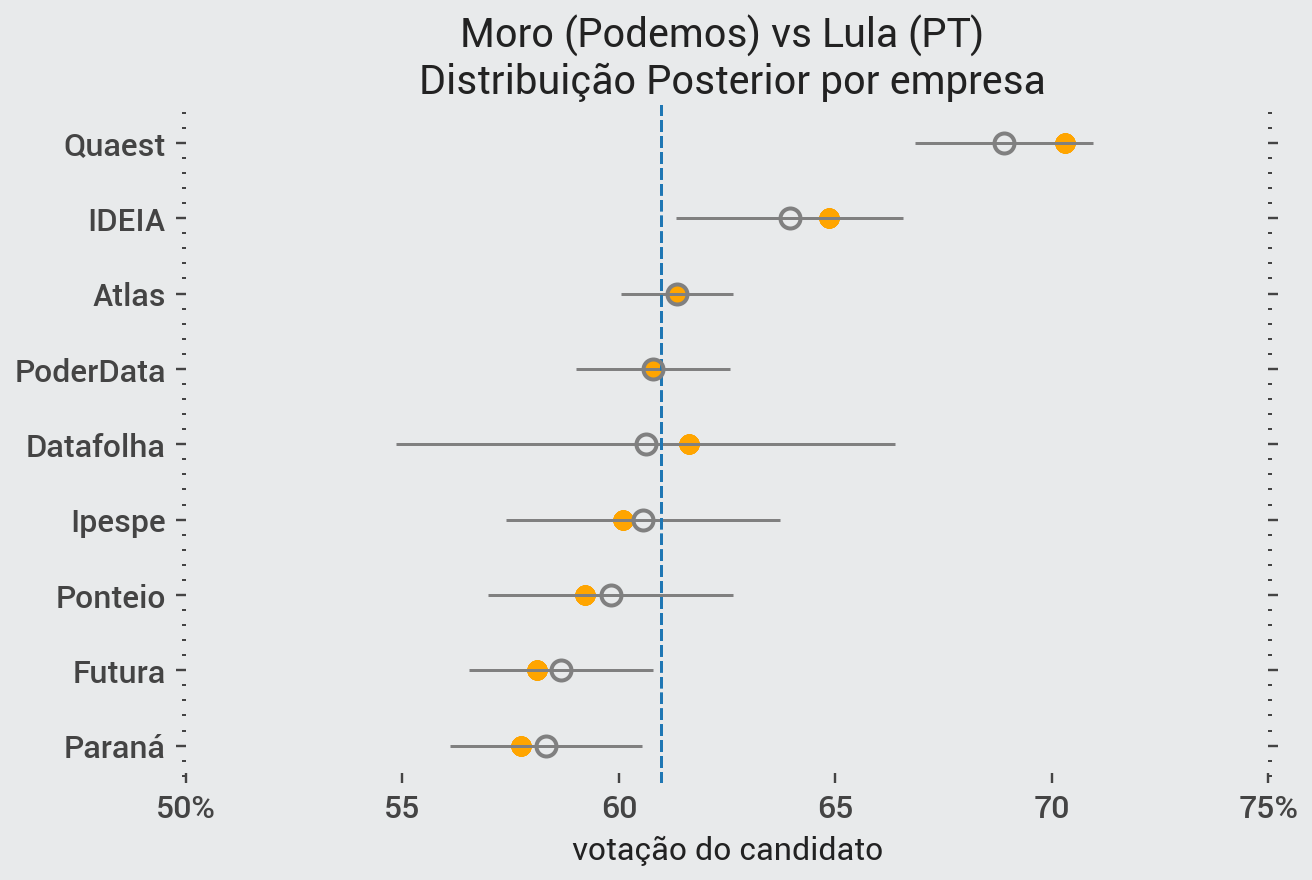

In [41]:
import scipy.stats as stats

medians = []
errs = []
labels = []
for empresa_idx in range(lula_moro_samples['thetas'].shape[1]):
    _median = np.mean(lula_moro_samples['thetas'][:,empresa_idx])
    lower, _ = np.percentile(lula_moro_samples['thetas'][:,empresa_idx], (10, 90))
    err = _median - lower
    
    medians.append(_median)
    errs.append(err)
    labels.append(lula_moro_empresas.index.tolist()[empresa_idx])
    
errs = [x for _,x in sorted(zip(medians, errs))]
labels = [x for _,x in sorted(zip(medians, labels))]
medians = sorted(medians)
#print(medians)

with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    #medians, errs, labels
    for idx, _median in enumerate(medians):
        plt.errorbar(x=_median, y=idx, xerr=errs[idx], fmt='o', color='gray')
        for empresa_idx, empresa in enumerate(labels):
            plt.scatter(
                x=(
                    lula_moro_empresas[lula_moro_empresas.index == empresa]['num_votos'] / 
                    lula_moro_empresas[lula_moro_empresas.index == empresa]['amostra']), 
                y=empresa_idx, color='orange')
        # plt.axvline(x=0.5, color='black', alpha=0.9, linewidth=1)
        plt.axvline(x=np.mean(lula_moro_samples['phi']), linestyle='--', color='tab:blue')
        plt.grid(linestyle=':')
        plt.yticks(np.arange(len(lula_moro_empresas)), labels)
        # plt.xlim([0.43, 0.57])
        plt.xlabel('votação do candidato')
        plt.title('Moro (Podemos) vs Lula (PT) \n Distribuição Posterior por empresa', fontsize=20)
        ax.set_xticks(ticks = [.50, .55, .60, .65, .70, .75])
        ax.set_xticklabels(labels = ['50%', '55', '60', '65', '70', '75%'])
        yticks, yticklabels = plt.yticks()
        ymin = (3*yticks[0] - yticks[1])/2.
        # shaft half a step to the right
        ymax = (3*yticks[-1] - yticks[-2])/2.
        plt.ylim(ymin, ymax)
        plt.yticks(yticks)

plt.savefig('../figures/lula_moro_tendendcia_empresa.png', dpi=300)

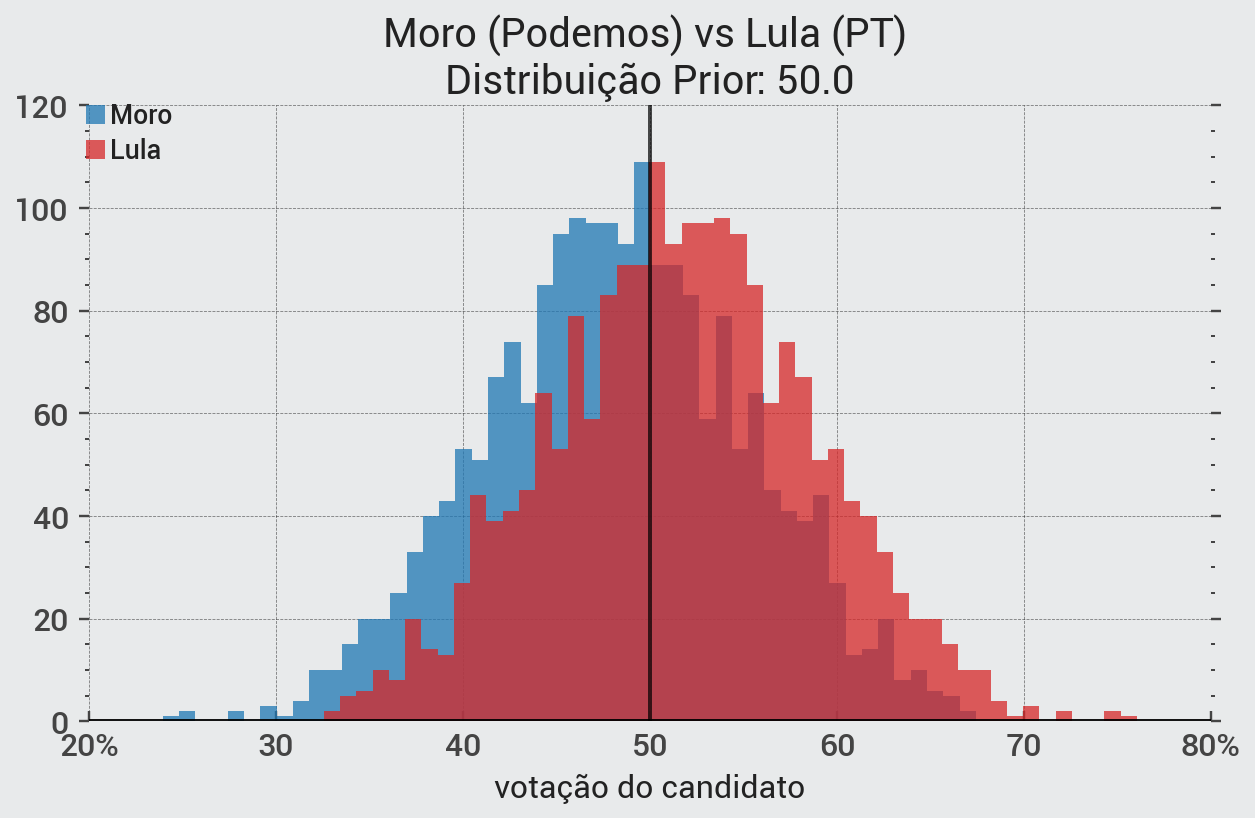

In [42]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_moro_prior['phi']), color='tab:blue', alpha=0.75, bins=50, label='Moro')
    ax.hist(lula_moro_prior['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Moro (Podemos) vs Lula (PT) \nDistribuição Prior: {}'.format(PRIOR_N), fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.20, .30, .40, .50, .60, .70, .80])
    ax.set_xticklabels(labels = ['20%', '30', '40', '50', '60', '70', '80%'])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();
    # save figure 
    plt.savefig('../figures/moro_lula_{}-priors.png'.format(PRIOR_N))

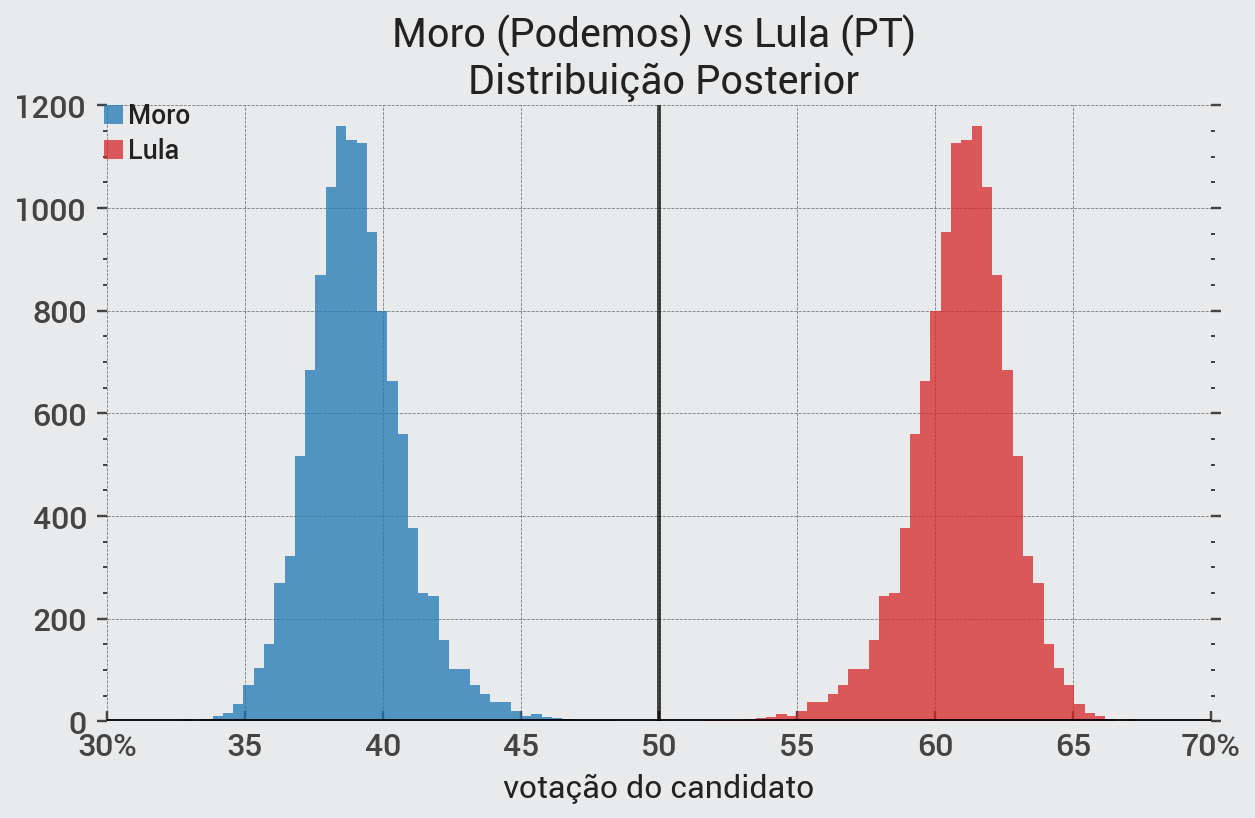

In [43]:
with plt.style.context(['jotaviz']):
    fig, ax = plt.subplots()
    ax.hist(1. - (lula_moro_samples['phi']), color='tab:blue', alpha=0.75, bins=50, label='Moro')
    ax.hist(lula_moro_samples['phi'], color='tab:red', alpha=0.75, bins=50, label='Lula')
    ax.set_title('Moro (Podemos) vs Lula (PT) \n Distribuição Posterior', fontsize=20)
    ax.set_xlabel(f'votação do candidato')
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.axvline(x = 0.5, color = 'black', linewidth = 2, alpha = .7)
    ax.axhline(y = 0, color = 'black', linewidth = 2, alpha = .7)
    ax.set_xticks(ticks = [.30, .35, .40, .45, .50, .55, .60, .65, .70])
    ax.set_xticklabels(labels = ['30%', '35', '40', '45', '50', '55', '60', '65', '70%'])
    plt.xlim([0.30, 0.70])
    #ax.grid(linestyle=':')
    ax.legend(loc="upper left")
    fig.tight_layout();

plt.savefig('../figures/moro_lula_posteriors.png')

In [44]:
print("Probabilidade de vitória de Lula no 2º turno:", round(np.mean(lula_moro_samples['phi'] > 0.55), 3));

print("Probabilidade de vitória de Moro no 2º turno:", round(np.mean(1. - lula_moro_samples['phi'] > 0.45), 3));

Probabilidade de vitória de Lula no 2º turno: 0.995
Probabilidade de vitória de Moro no 2º turno: 0.005
